In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath_hi = '../../data/processed/hi_rws_0001_0256_topics.csv'
df = pd.read_csv(filepath_hi)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195766 entries, 0 to 195765
Data columns (total 12 columns):
lsi_5_topic_mode                          195762 non-null float64
lsi_5_topic_mode_prob                     195766 non-null object
lsi_5_topic_list                          195766 non-null object
lsi_logentropy_topic_mode                 195766 non-null int64
lsi_logentropy_topic_mode_prob            195766 non-null object
lsi_logentropy_topic_list                 195766 non-null object
lsi_random_projections_topic_mode         195223 non-null float64
lsi_random_projections_topic_mode_prob    195761 non-null object
lsi_random_projections_topic_list         195766 non-null object
lda_5_topic_mode                          195766 non-null int64
lda_5_topic_mode_prob                     195766 non-null object
lda_5_topic_list                          195766 non-null object
dtypes: float64(2), int64(2), object(8)
memory usage: 17.9+ MB


In [2]:
[i for i in df.columns if i.endswith('_mode')]

['lsi_5_topic_mode',
 'lsi_logentropy_topic_mode',
 'lsi_random_projections_topic_mode',
 'lda_5_topic_mode']

## Document Topic Distributions

In [3]:
df.lsi_5_topic_mode.value_counts().sort_index()

0.0     40932
1.0     12314
2.0     31078
3.0    111391
4.0        47
Name: lsi_5_topic_mode, dtype: int64

In [4]:
df.lsi_logentropy_topic_mode.value_counts().sort_index()

0    163855
1     24963
2         1
3      4085
4      2862
Name: lsi_logentropy_topic_mode, dtype: int64

In [5]:
df.lsi_random_projections_topic_mode.value_counts().sort_index()

0.0    55552
1.0    41807
2.0    38526
3.0    27917
4.0    31421
Name: lsi_random_projections_topic_mode, dtype: int64

In [6]:
df.lda_5_topic_mode.value_counts().sort_index()

0    32641
1    44553
2    34224
3    57787
4    26561
Name: lda_5_topic_mode, dtype: int64

In [ ]:
# all topics frequency distribution 
import matplotlib.pyplot as plt

topic_models_list = [i for i in df.columns if i.endswith('_mode')]
# topic_models_list.remove('lda_random_projections_topic_mode')
fig, axes = plt.subplots(len(topic_models_list), 2, figsize=(15, 20))

for i, model in enumerate(topic_models_list):
    topic_freqs = df[model].value_counts().sort_index().plot(ax=axes[i, 0], title='mode frequencies')
    pd_topic_frequencies = df[model+'_prob'].apply(lambda x: pd.Series(x.split(',')).value_counts()).fillna(0)
    topic_sent_freqs = pd_topic_frequencies.sum().sort_index().plot(ax=axes[i, 1], title='sent topic frequencies')

plt.show()

In [9]:
pd_topic_frequencies = df.lda_5_topic_mode_prob.apply(lambda x: pd.Series(x.split(',')).value_counts()) #.fillna(0)

In [ ]:
pd_topic_frequencies = pd_topic_frequencies.fillna(0).reindex(columns=sorted(pd_topic_frequencies))
pd_topic_frequencies.columns = [f'topic_{i}' for i in range(5)]
pd_topic_frequencies.head()

In [ ]:
pd_lda_5_mode = df.lda_5_topic_mode.copy()
pd_lda_5_mode.name = 'topic_score'
pd.concat([pd_topic_frequencies, pd_lda_5_mode], axis=1)

In [ ]:
pd_topic_frequencies.sum().transpose().sort_index().plot()

In [ ]:
pd_topic_frequencies[sorted(pd_topic_frequencies.columns)]

## Topics Models

### Model Coherence and Evaluation

In [7]:
import itertools
import ast
 
df2 = pd.read_csv('../../data/processed/hi_rws_0001_0256_complete.csv', nrows=None)
revs = df2.norm_tokens_doc.apply(lambda x: ast.literal_eval(x))
docs = list(itertools.chain(*revs))

In [58]:
df_test = df2.description
df_test.to_csv()# [:5]

NameError: name 'df2' is not defined

In [ ]:
# load models
# doc_term_matrix needs to be loaded
from gensim.models import LdaModel, LsiModel
from gensim.models import CoherenceModel

models_list = [i.split('_topic_mode')[0] for i in df.columns if i.endswith('topic_mode')]
zipped = zip(models_list, (doc_term_matrix, doc_term_matrix_logentropy, 
     doc_term_matrix_random_projections, doc_term_matrix))

coherence_list = []
topic_coherence_list = []
loaded_models_list = []
for model, doc_term_matrix in zipped:
    model_path = f'../../model/{model[:3]}_model/{model}.model'
    loaded_model = LdaModel.load(model_path) if model[:3] == 'lda' else LsiModel.load(model_path)
    loaded_models_list.append(loaded_model)
    
    coherencemodel = CoherenceModel(model=loaded_model, corpus=doc_term_matrix, texts=docs, coherence='c_v')
    topic_coherences = coherencemodel.get_coherence_per_topic()
    topic_coherence_list.append((model, topic_coherences))
    coherence_list.append(round(coherencemodel.get_coherence(), 4))
    print(loaded_model)

In [ ]:
pd_topic_coherence_list = []
for model, topic_coherence in topic_coherence_list:
    pd_topic_coherence_list.append(pd.Series(topic_coherence, name=model))
print(coherence_list)
pd.concat(pd_topic_coherence_list, axis=1).transpose()

In [ ]:
from gensim.models import LdaModel, LsiModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
import itertools

topic_num_list = list(itertools.product(['lsi', 'lda'], range(2, 15, 3)))

model_list = []
coherence_list = []

for (model, num_topics) in topic_num_list:
    model_path = f'../../model/{model}_model/{model}_{num_topics}.model'
    loaded_model = LdaModel.load(model_path) if model == 'lda' else LsiModel.load(model_path)
    model_list.append(loaded_model)
    coherencemodel = CoherenceModel(model=loaded_model, corpus=doc_term_matrix, texts=docs, coherence='c_v')
    coherence_list.append((model, num_topics, coherencemodel.get_coherence()))
pd.DataFrame(coherence_list, columns=['model', 'num_topics', 'coherence_score'])

### Model, Words, and WordCloud 

In [7]:
import pickle
obj_name_list = [
    'id2word', 
    'doc_term_matrix', 
    'doc_term_matrix_random_projections', 
    'doc_term_matrix_tfidf', 
    'doc_term_matrix_logentropy'
]
obj_list = []
for name in obj_name_list:
    with open(f'../../model-server/dict_and_matrix/{name}.pkl', 'rb') as f:
        obj = pickle.load(f)
        obj_list.append(obj)
        print(obj)

id2word, doc_term_matrix, doc_term_matrix_random_projections, doc_term_matrix_tfidf, doc_term_matrix_logentropy = obj_list

Dictionary(34789 unique tokens: ['great', 'lunch', 'maui', 'ocean', 'overlook']...)


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath_hi = '../../data-server/processed/hi_rws_0001_0256_topics.csv'
df = pd.read_csv(filepath_hi)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195766 entries, 0 to 195765
Data columns (total 36 columns):
lsi_5_topic_mode                          195762 non-null float64
lsi_5_topic_mode_prob                     195766 non-null object
lsi_5_topic_list                          195766 non-null object
lsi_2_topic_mode                          195764 non-null float64
lsi_2_topic_mode_prob                     195766 non-null object
lsi_2_topic_list                          195766 non-null object
lsi_8_topic_mode                          195760 non-null float64
lsi_8_topic_mode_prob                     195766 non-null object
lsi_8_topic_list                          195766 non-null object
lsi_14_topic_mode                         195759 non-null float64
lsi_14_topic_mode_prob                    195766 non-null object
lsi_14_topic_list                         195766 non-null object
lsi_logentropy_topic_mode                 195766 non-null int64
lsi_logentropy_topic_mode_prob           

In [10]:
[i for i in df.columns if i.endswith('_mode')]

['lsi_5_topic_mode',
 'lsi_logentropy_topic_mode',
 'lsi_random_projections_topic_mode',
 'lda_5_topic_mode']

In [11]:
from gensim.models import LdaModel, LsiModel
from gensim.corpora import Dictionary
import itertools

models_list = [i.split('_topic_mode')[0] for i in df.columns if i.endswith('topic_mode')]
loaded_models_list = []

for index, model in enumerate(models_list):
    model_path = f'../../model/{model[:3]}_model/{model}.model'
    loaded_model = LdaModel.load(model_path) if model[:3] == 'lda' else LsiModel.load(model_path)
    print(index, loaded_model)
    loaded_models_list.append(loaded_model)

0 LsiModel(num_terms=34220, num_topics=5, decay=1.0, chunksize=20000)
1 LsiModel(num_terms=34220, num_topics=5, decay=1.0, chunksize=20000)
2 LsiModel(num_terms=34220, num_topics=5, decay=1.0, chunksize=20000)
3 LdaModel(num_terms=34220, num_topics=5, decay=0.5, chunksize=2000)


In [12]:
for index, model in enumerate(loaded_models_list):
    print(index, '\n', model.show_topics(num_words=2))

0 
 [(0, '0.854*"have" + 0.337*"good"'), (1, '0.692*"good" + -0.465*"have"'), (2, '-0.611*"good" + 0.540*"food"'), (3, '0.639*"place" + -0.504*"food"'), (4, '-0.661*"fish" + -0.359*"order"')]
1 
 [(0, '0.757*"good" + 0.390*"food"'), (1, '0.582*"great" + -0.578*"good"'), (2, '-0.398*"have" + -0.372*"place"'), (3, '-0.510*"fish" + -0.442*"taco"'), (4, '0.885*"shave" + -0.327*"view"')]
2 
 [(0, '0.660*"ocean" + 0.487*"maui"'), (1, '0.602*"lunch" + 0.579*"great"'), (2, '0.720*"great" + -0.527*"maui"'), (3, '-0.857*"overlook" + -0.509*"ocean"'), (4, '0.680*"maui" + -0.624*"lunch"')]
3 
 [(0, '0.030*"would" + 0.027*"have"'), (1, '0.088*"food" + 0.070*"great"'), (2, '0.040*"maui" + 0.039*"have"'), (3, '0.049*"have" + 0.022*"fish"'), (4, '0.048*"good" + 0.038*"have"')]


In [18]:
# make a dataframe from words
topic_words = loaded_models_list[3].show_topics(num_words=500, formatted=False)

topics_list = []
for (topic, word_list) in topic_words:
    temp = pd.DataFrame(word_list, columns=[f'{topic}_word', f'{topic}_prob'])
    topics_list.append(temp)
pd_topics = pd.concat(topics_list, axis=1)
pd_topics.to_csv('../../data/processed/hi_rws_0001_0256_topics_words.csv', index=False)
pd_topics.head(10)

,0_word,0_prob,1_word,1_prob,2_word,2_prob,3_word,3_prob,4_word,4_prob
0,would,0.030416,food,0.087639,maui,0.039586,have,0.048876,good,0.048150
1,have,0.027189,great,0.070021,have,0.039106,fish,0.021965,have,0.037942
2,make,0.025974,service,0.048152,time,0.036191,good,0.020559,lavender,0.024558
3,pizza,0.017853,place,0.032486,will,0.023239,order,0.020541,menu,0.016317
4,place,0.017711,good,0.029082,come,0.020873,fresh,0.017451,what,0.014062
5,recommend,0.017591,nice,0.028980,dinner,0.019128,delicious,0.016919,coffee,0.014051
6,worth,0.016327,view,0.024394,visit,0.017332,which,0.015894,more,0.013133
7,table,0.016000,friendly,0.022037,lunch,0.017114,burger,0.015289,price,0.013016
8,wait,0.015415,amazing,0.019831,place,0.016936,salad,0.013672,other,0.012554
9,give,0.014828,beautiful,0.019566,stop,0.015097,mahi,0.010815,dessert,0.012301


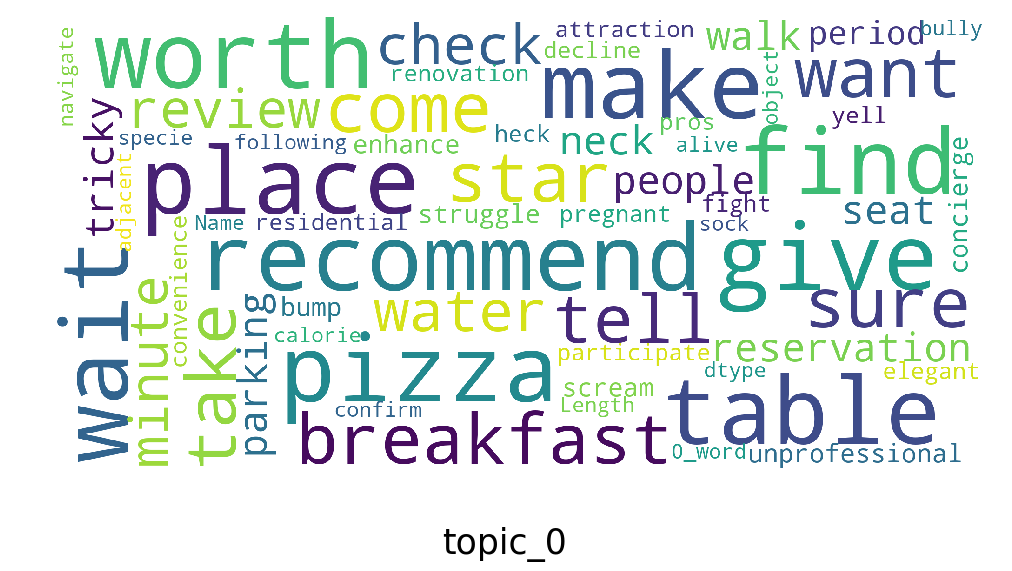

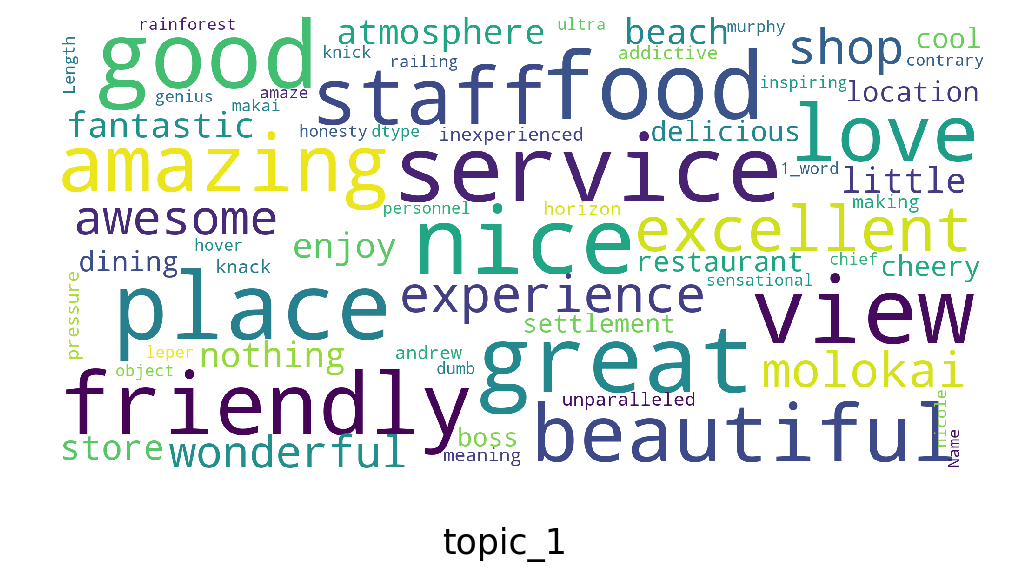

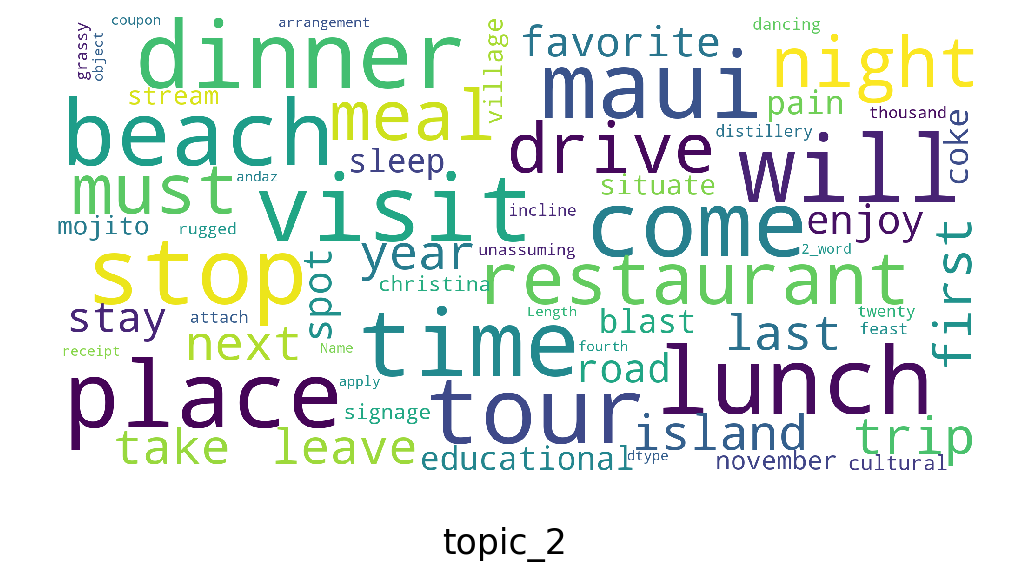

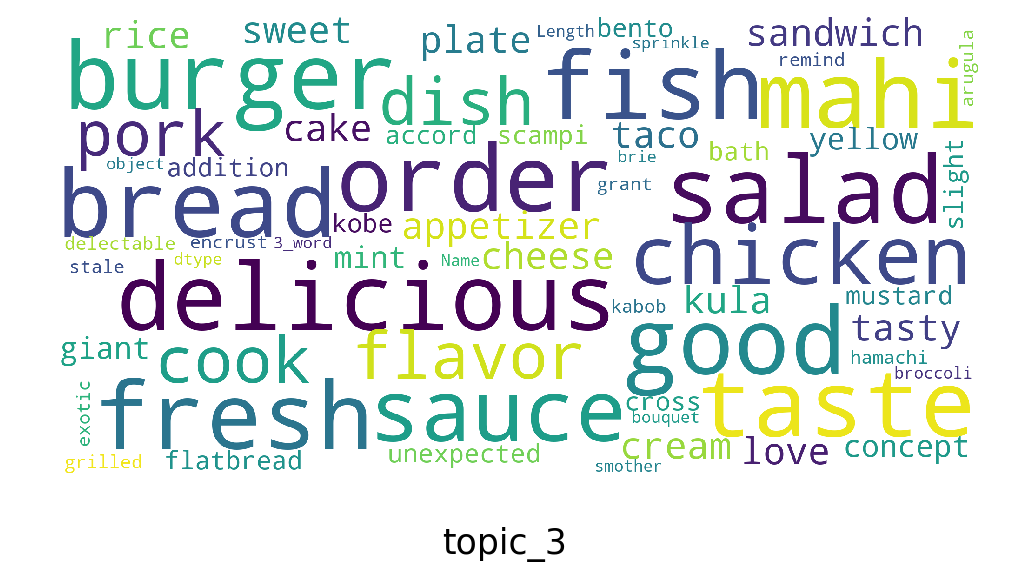

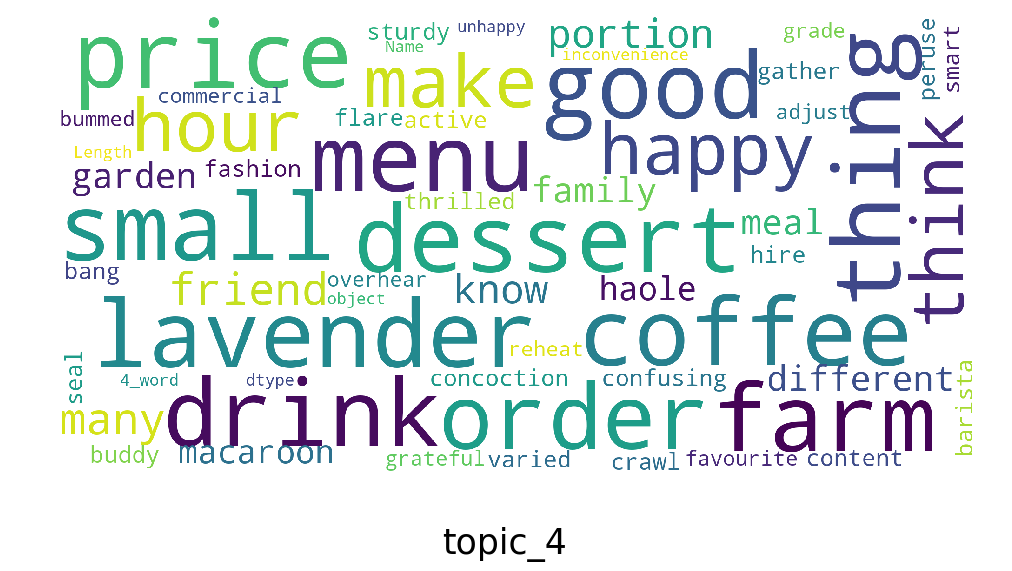

In [17]:
# words in the topics for selected model
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

for i in range(len(topics_list)):
    wordcloud = WordCloud(
            background_color='white',
            # stopwords=stopwords,
            max_words=400,
            max_font_size=40, 
            scale=5,
            random_state=1 # chosen at random by flipping a coin; it was heads
        ).generate(str(pd_topics[f'{i}_word']))

    fig = plt.figure(1, figsize=(12, 12), dpi=100)    
    fig.suptitle(f'topic_{i}', fontsize=25)
    fig.subplots_adjust(top=2.3)
    plt.axis('off')
    plt.imshow(wordcloud)     
    # plt.savefig(f'../../data/processed/hi_rws_0001_0256_topic_{i}.png')  
    plt.show()

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(topic_model=loaded_models_list[7] , corpus=doc_term_matrix, dictionary=id2word)